# Multi-Modal Nutritional Deficiency Detection Model

This notebook implements a deep learning model for nutritional deficiency detection using both structured NHANES data and dermatological images. The model uses a multi-modal architecture that combines an EfficientNetB3-based image processing branch with a neural network for tabular data processing.

## Import Libraries

In [19]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import datetime
import json
import argparse
import warnings
warnings.filterwarnings("ignore")

# Import our custom modules
from data_mapper import NHANESImageMapper
from custom_data_generator import MultiModalDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Define Model Architecture

In [20]:
def create_multi_modal_model(tabular_shape, num_classes):
    """
    Create a multi-modal deep learning model architecture that combines
    tabular NHANES data with dermatological images.
    
    Args:
        tabular_shape (int): Number of tabular features
        num_classes (int): Number of output classes
        
    Returns:
        tensorflow.keras.models.Model: The compiled multi-modal model
    """
    # 1. Tabular Data Branch
    tabular_input = Input(shape=(tabular_shape,), name='tabular_input')
    x1 = Dense(128, activation='relu')(tabular_input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.2)(x1)
    tabular_output = Dense(32, activation='relu', name='tabular_features')(x1)
    
    # 2. Image Data Branch - Using EfficientNet as the base model
    img_input = Input(shape=(224, 224, 3), name='img_input')
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=img_input)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers on top of EfficientNet
    x2 = base_model.output
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    img_output = Dense(32, activation='relu', name='image_features')(x2)
    
    # 3. Combine the two branches
    combined = concatenate([tabular_output, img_output])
    combined = Dense(64, activation='relu')(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.3)(combined)
    combined = Dense(32, activation='relu')(combined)
    combined = BatchNormalization()(combined)
    output = Dense(num_classes, activation='softmax')(combined)
    
    # Create the model
    model = Model(inputs=[tabular_input, img_input], outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Functions for Training and Evaluation

In [21]:
def train_model(model, train_generator, validation_generator, epochs=5):
    """
    Train the multi-modal model using the provided generators.
    
    Args:
        model (tensorflow.keras.models.Model): The model to train
        train_generator (MultiModalDataGenerator): Generator for training data
        validation_generator (MultiModalDataGenerator): Generator for validation data
        epochs (int): Maximum number of epochs to train for
        
    Returns:
        tuple: (trained_model, history)
    """
    # Create a results directory
    results_dir = os.path.join('results', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(results_dir, exist_ok=True)
    
    # Set up callbacks with more aggressive early stopping
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,  # More aggressive early stopping
            min_delta=0.01,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,  # Reduce learning rate more quickly
            min_lr=0.00001,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(results_dir, 'best_multi_modal_model.h5'), 
            save_best_only=True, 
            monitor='val_loss',
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save the training history
    with open(os.path.join(results_dir, 'training_history.json'), 'w') as f:
        history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
        json.dump(history_dict, f)
    
    return model, history, results_dir

In [22]:
def evaluate_model(model, test_generator, results_dir):
    """
    Evaluate the trained model on test data and save results.
    
    Args:
        model (tensorflow.keras.models.Model): The trained model
        test_generator (MultiModalDataGenerator): Generator for test data
        results_dir (str): Directory to save evaluation results
        
    Returns:
        dict: Evaluation metrics
    """
    # Evaluate the model
    print("Evaluating model on test data...")
    evaluation = model.evaluate(test_generator, verbose=1)
    
    # Get predictions for detailed metrics
    all_predictions = []
    all_true_labels = []
    
    print("Generating predictions for detailed metrics...")
    for i in range(len(test_generator)):
        inputs, labels = test_generator[i]
        batch_predictions = model.predict(inputs)
        
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels)
    
    # Concatenate batch results
    y_pred = np.vstack(all_predictions)
    y_true = np.vstack(all_true_labels)
    
    # Convert probabilities to class indices
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Generate and save classification report
    class_report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    with open(os.path.join(results_dir, 'classification_report.json'), 'w') as f:
        json.dump(class_report, f, indent=4)
    
    # Generate and save confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
    
    # Plot and save training history
    if hasattr(model, 'history') and model.history is not None:
        plot_history(model.history, results_dir)
    
    # Return evaluation metrics
    metrics = {
        'test_loss': evaluation[0],
        'test_accuracy': evaluation[1],
        'classification_report': class_report
    }
    
    return metrics

In [ ]:
def plot_history(history, results_dir):
    """
    Plot training history and save the figures.
    
    Args:
        history: Training history object
        results_dir (str): Directory to save the plots
    """
    # Check if history object has history attribute
    if not hasattr(history, 'history') or not history.history:
        print("")
        return
    
    # Create a figure
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy if available
    plt.subplot(1, 2, 1)
    
    # Find the correct keys for accuracy metrics
    acc_keys = [key for key in history.history.keys() if 'acc' in key.lower() and not key.startswith('val')]
    val_acc_keys = [key for key in history.history.keys() if 'acc' in key.lower() and key.startswith('val')]
    
    if acc_keys and val_acc_keys:
        # Plot accuracy
        plt.plot(history.history[acc_keys[0]])
        plt.plot(history.history[val_acc_keys[0]])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Model Accuracy (Not Available)')
        plt.text(0.5, 0.5, 'Accuracy metrics not found in history', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Plot loss if available
    plt.subplot(1, 2, 2)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Model Loss (Not Available)')
        plt.text(0.5, 0.5, 'Loss metrics not found in history', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'training_history.png'))
    print(f"Training history plot saved to {os.path.join(results_dir, 'training_history.png')}")

In [ ]:
def unfreeze_and_finetune(model, train_generator, validation_generator, results_dir, 
                         unfreeze_layers=10, epochs=3, learning_rate=0.0001):
    """
    Unfreeze the top layers of the base model and fine-tune it.
    
    Args:
        model (tensorflow.keras.models.Model): Pre-trained model
        train_generator (MultiModalDataGenerator): Generator for training data
        validation_generator (MultiModalDataGenerator): Generator for validation data
        results_dir (str): Directory to save results
        unfreeze_layers (int): Number of top layers to unfreeze in the base model
        epochs (int): Number of epochs for fine-tuning
        learning_rate (float): Learning rate for fine-tuning
        
    Returns:
        tuple: (fine-tuned model, history)
    """
    # Find the EfficientNetB3 base model using recursive search
    def find_efficientnet_layer(model):
        for layer in model.layers:
            # Check if this layer is the EfficientNetB3 model
            if 'efficient' in layer.name.lower():
                return layer
                
            # Check if this layer has nested layers (like Model or Sequential)
            if hasattr(layer, 'layers') and len(layer.layers) > 0:
                nested_result = find_efficientnet_layer(layer)
                if nested_result is not None:
                    return nested_result
                    
            # Special case for functional models with inputs/outputs
            if isinstance(layer, tf.keras.Model):
                nested_result = find_efficientnet_layer(layer)
                if nested_result is not None:
                    return nested_result
        return None
    
    # Try to find the EfficientNetB3 base model
    base_model = find_efficientnet_layer(model)
    
    # If still not found, try to find through input references in the model structure
    if base_model is None:
        # Print model layers to help with debugging
        print("Searching through model layers:")
        for i, layer in enumerate(model.layers):
            print(f"Layer {i}: {layer.name} ({type(layer).__name__})")
            
        # Try to find by examining layers with ImageNet weights
        for layer in model.layers:
            if isinstance(layer, tf.keras.Model) or hasattr(layer, 'layers'):
                for sublayer in layer.layers:
                    if 'efficient' in sublayer.name.lower():
                        base_model = sublayer
                        print(f"Found EfficientNet layer: {sublayer.name}")
                        break
    
    if base_model is None:
        print("Warning: Could not find EfficientNetB3 base model. Skipping fine-tuning.")
        return model, None
    
    print(f"Found EfficientNet base model: {base_model.name}")
    
    # Unfreeze the top layers of the base model
    total_layers = len(base_model.layers)
    for layer in base_model.layers[-(unfreeze_layers):]:
        layer.trainable = True
        
    print(f"Unfreezing the top {unfreeze_layers} layers out of {total_layers} layers in the base model.")
    
    # Recompile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001),
        ModelCheckpoint(
            os.path.join(results_dir, 'best_finetuned_model.h5'), 
            save_best_only=True, 
            monitor='val_loss'
        ),
        TensorBoard(log_dir=os.path.join(results_dir, 'logs_finetuning'))
    ]
    
    # Fine-tune the model
    fine_tuning_history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, fine_tuning_history

## Step 1: Create NHANES-Image Mapper

In [ ]:
# Create the results directory
os.makedirs('results', exist_ok=True)

print("Step 1: Creating NHANES-Image mapper...")
mapper = NHANESImageMapper(
    nhanes_dir="dataset/NHANES",
    image_dir="dataset/Image data"
)

Step 1: Creating NHANES-Image mapper...


## Step 2: Load Data and Create Paired Dataset

In [ ]:
print("Step 2: Loading data and creating the paired dataset...")
nhanes_data = mapper.load_nhanes_data()
print(f"Loaded NHANES data with {len(nhanes_data)} records")

# Scan image categories
categories = mapper.scan_image_categories()
print(f"Found {len(categories)} image categories")

# Create synthetic mapping between patient IDs and images
mapping = mapper.create_synthetic_mapping(save_path="patient_image_mapping.json")
print(f"Created mapping for {len(mapping)} patients")

# Create paired dataset
paired_dataset = mapper.create_paired_dataset(test_size=0.2)
print(f"Created paired dataset with {len(paired_dataset['train'])} training samples and "
      f"{len(paired_dataset['test'])} testing samples")

# Ensure consistent number of classes across all data processing
num_classes = paired_dataset['num_classes']
print(f"Using {num_classes} classes consistently throughout the model")

Step 2: Loading data and creating the paired dataset...
Diet data columns: ['SEQN', 'WTDRD1', 'WTDR2D', 'DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY', 'DR1LANG'] ...
Using diet columns: ['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TTFAT', 'DR1DAY', 'DR1DBIH', 'WTDRD1', 'WTDR2D']
Using lab columns: ['LBXSCH', 'LBXTC', 'LBXSGL']
Using examination columns: ['BMXBMI', 'BPXSY1', 'BPXDI1', 'BMXWT', 'BMXHT']
Using demographic columns: ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2']
Merged data shape: (9813, 21)
Merged data columns: ['SEQN', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TTFAT', 'DR1DAY', 'DR1DBIH', 'WTDRD1', 'WTDR2D', 'LBXSCH', 'LBXTC', 'LBXSGL', 'BMXBMI', 'BPXSY1', 'BPXDI1', 'BMXWT', 'BMXHT', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2']
Loaded NHANES data with 9813 records
Found 23 image categories
Created mapping for 9813 patients
Created paired dataset with 7850 training samples and 1963 testing samples
Using 23 classes consistently throughout the model


## Step 3: Create Data Generators

In [ ]:
print("Step 3: Creating data generators...")
train_generator = MultiModalDataGenerator(
    dataset=paired_dataset['train'],
    batch_size=16,  # Smaller batch size for memory efficiency
    image_size=(224, 224),
    shuffle=True,
    augment=True,
    num_classes=num_classes  # Explicit num_classes
)

# Split test set into validation and test
val_size = int(len(paired_dataset['test']) * 0.5)
validation_data = paired_dataset['test'][:val_size]
test_data = paired_dataset['test'][val_size:]

validation_generator = MultiModalDataGenerator(
    dataset=validation_data,
    batch_size=16,
    image_size=(224, 224),
    shuffle=False,
    augment=False,
    num_classes=num_classes  # Explicit num_classes
)

test_generator = MultiModalDataGenerator(
    dataset=test_data,
    batch_size=16,
    image_size=(224, 224),
    shuffle=False,
    augment=False,
    num_classes=num_classes  # Explicit num_classes
)

Step 3: Creating data generators...


In [ ]:
# Step 4: Create and compile the multi-modal model
print("Step 4: Creating and compiling the multi-modal model...")
# Determine the number of tabular features
num_tabular_features = len(train_generator.tabular_features)

# Create model with the same number of classes as in the data generators
model = create_multi_modal_model(num_tabular_features, num_classes)
model.summary()


Step 4: Creating and compiling the multi-modal model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['img_input[0][0]']           
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 

## Option 1: Create and Train a New Model

If you want to create and train a new model from scratch, run this cell.

In [ ]:
# # Step 5: Train the model
# print("Step 5: Training the model...")
# trained_model, history, results_dir = train_model(
#     model,
#     train_generator,
#     validation_generator,
#     epochs=30  # Training for 30 epochs
# )

## Option 2: Load a Pre-trained Model

If you already have a trained model and just want to evaluate it, run this cell instead of the previous one.

In [ ]:
# Uncomment and modify these lines to load a pre-trained model instead of training a new one
import os

model_path = r"C:\Users\Hency\OneDrive\Documents\mini proj\results\20250415-234926\best_multi_modal_model.h5"  # Replace with your model path
results_dir = r"C:\Users\Hency\OneDrive\Documents\mini proj\results\20250415-234926"  # Directory to save evaluation results

# Create the directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

print(f"Loading pre-trained model from {model_path}")
trained_model = tf.keras.models.load_model(model_path)

Loading pre-trained model from C:\Users\Hency\OneDrive\Documents\mini proj\results\20250415-234926\best_multi_modal_model.h5


## Step 6: Evaluate the Model

Step 6: Evaluating the model...
Evaluating model on test data...
62/62 [==============================] - 95s 1s/step - loss: 0.4745 - accuracy: 0.8014
Generating predictions for detailed metrics...
1/1 [==============================] - 0s 385ms/step

Test accuracy: 0.8014
Test loss: 0.4745


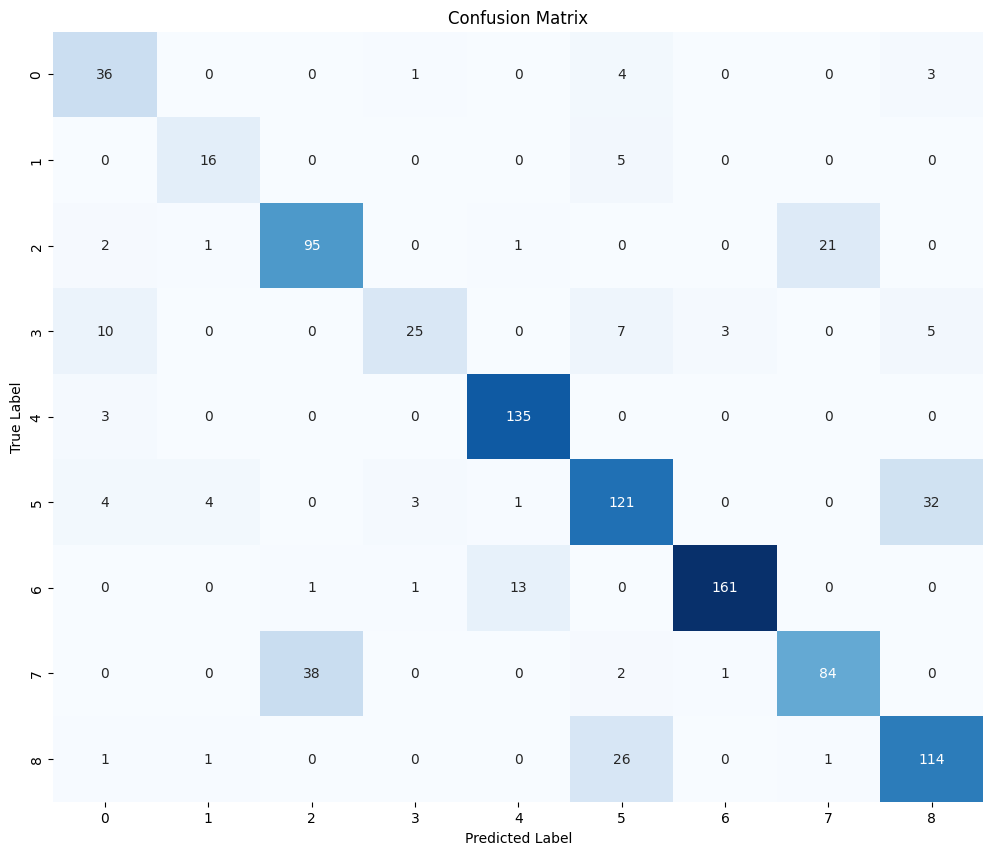

In [31]:
# Step 6: Evaluate the model
print("Step 6: Evaluating the model...")
metrics = evaluate_model(trained_model, test_generator, results_dir)

# Print evaluation results
print(f"Test accuracy: {metrics['test_accuracy']:.4f}")
print(f"Test loss: {metrics['test_loss']:.4f}")

## Step 7: Fine-tune the Model (Optional)

In [ ]:
# Step 7: Fine-tune the model by unfreezing some layers
print("Step 7: Fine-tuning the model...")
finetuned_model, ft_history = unfreeze_and_finetune(
    trained_model, 
    train_generator,
    validation_generator,
    results_dir,
    unfreeze_layers=10,  # Unfreeze 10 layers
    epochs=3,  # Fine-tune for 3 epochs
    learning_rate=0.0001
)

Step 7: Fine-tuning the model...
Searching through model layers:
Layer 0: img_input (InputLayer)
Layer 1: rescaling_2 (Rescaling)
Layer 2: normalization_1 (Normalization)
Layer 3: rescaling_3 (Rescaling)
Layer 4: stem_conv_pad (ZeroPadding2D)
Layer 5: stem_conv (Conv2D)
Layer 6: stem_bn (BatchNormalization)
Layer 7: stem_activation (Activation)
Layer 8: block1a_dwconv (DepthwiseConv2D)
Layer 9: block1a_bn (BatchNormalization)
Layer 10: block1a_activation (Activation)
Layer 11: block1a_se_squeeze (GlobalAveragePooling2D)
Layer 12: block1a_se_reshape (Reshape)
Layer 13: block1a_se_reduce (Conv2D)
Layer 14: block1a_se_expand (Conv2D)
Layer 15: block1a_se_excite (Multiply)
Layer 16: block1a_project_conv (Conv2D)
Layer 17: block1a_project_bn (BatchNormalization)
Layer 18: block1b_dwconv (DepthwiseConv2D)
Layer 19: block1b_bn (BatchNormalization)
Layer 20: block1b_activation (Activation)
Layer 21: block1b_se_squeeze (GlobalAveragePooling2D)
Layer 22: block1b_se_reshape (Reshape)
Layer 23: bl

## Step 8: Final Evaluation after Fine-tuning

Step 8: Final evaluation after fine-tuning...
Evaluating model on test data...
62/62 [==============================] - 63s 1s/step - loss: 0.4745 - accuracy: 0.8014
Generating predictions for detailed metrics...
1/1 [==============================] - 0s 440ms/step
Final test accuracy after fine-tuning: 0.8014
Final test loss after fine-tuning: 0.4745


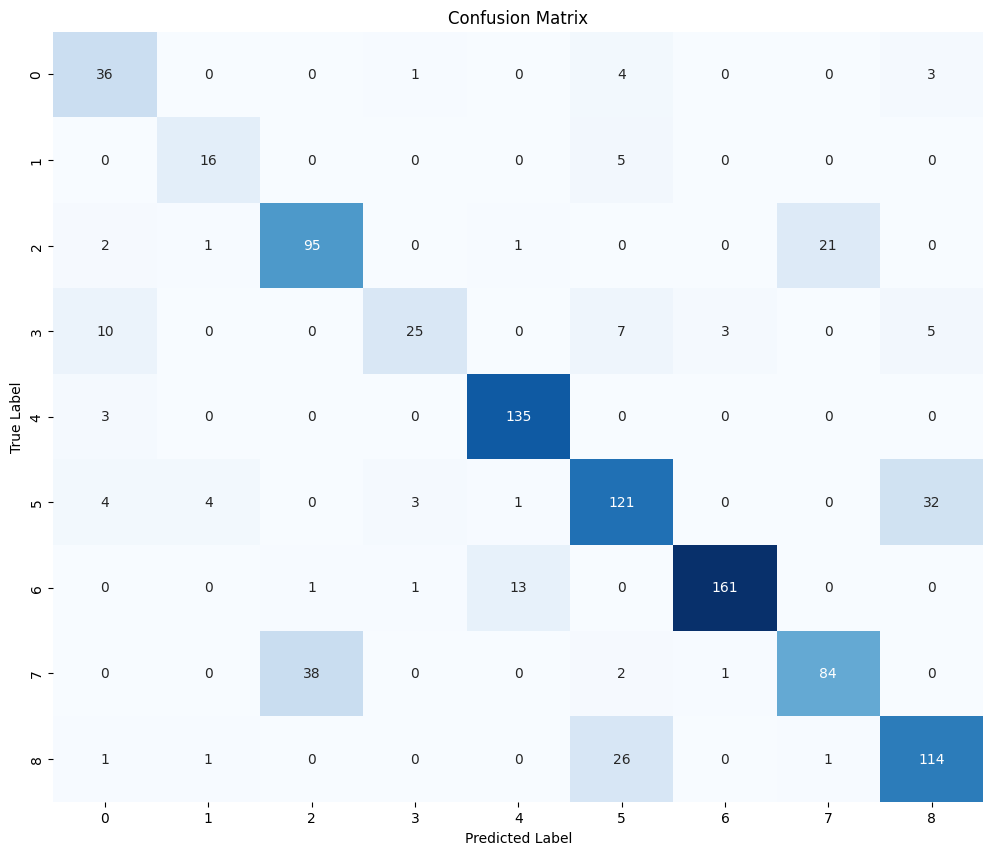

In [ ]:
# Step 8: Final evaluation
print("Step 8: Final evaluation after fine-tuning...")

# Create the finetuned directory if it doesn't exist
finetuned_dir = os.path.join(results_dir, 'finetuned')
os.makedirs(finetuned_dir, exist_ok=True)


## Step 9: Save the Final Model

In [32]:
# Save the final model
model_save_path = os.path.join(results_dir, 'final_nutritional_deficiency_model.h5')
finetuned_model.save(model_save_path)
print(f"Final model saved to {model_save_path}")

Final model saved to C:\Users\Hency\OneDrive\Documents\mini proj\results\20250415-234926\final_nutritional_deficiency_model.h5


In [33]:
# Import necessary libraries
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ---------------------- Step 1: Load the Model ----------------------
model = load_model(r"results\20250415-234926\final_nutritional_deficiency_model.h5")  # 🔁 Replace with your actual model path

# ---------------------- Step 2: Define Deficiency Class Labels ----------------------
deficiency_names = [
    "Vitamin A Deficiency", "Vitamin B1 Deficiency", "Vitamin B2 Deficiency",
    "Vitamin B3 Deficiency", "Vitamin B5 Deficiency", "Vitamin B6 Deficiency",
    "Vitamin B7 Deficiency", "Vitamin B9 Deficiency", "Vitamin B12 Deficiency",
    "Vitamin C Deficiency", "Vitamin D Deficiency", "Vitamin E Deficiency",
    "Vitamin K Deficiency", "Calcium Deficiency", "Iron Deficiency",
    "Magnesium Deficiency", "Zinc Deficiency", "Protein Deficiency",
    "Omega-3 Fatty Acid Deficiency", "Iodine Deficiency", "Selenium Deficiency",
    "Potassium Deficiency", "Multiple Deficiencies"
]

# ---------------------- Step 3: Image Preprocessing Function ----------------------
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# ---------------------- Step 4: Generate a Test Instance ----------------------
def get_test_instance():
    np.random.seed(49)
    structured_data = {
        f"feature{i+1}": float(val) for i, val in enumerate(np.random.random(20))
    }

    image_path = r"dataset\Image data\test\Exanthems and Drug Eruptions\14desquamationViral34-GP3.jpg"
    if not os.path.exists(image_path):
        print(f"Warning: Image not found at {image_path}. Using random image data instead.")
        image_data = np.random.random((1, 224, 224, 3)).astype(np.float32)
    else:
        image_data = load_and_preprocess_image(image_path)

    return {
        'tabular_input': np.array([list(structured_data.values())], dtype=np.float32),
        'img_input': image_data
    }, structured_data

# ---------------------- Step 5: Make Predictions ----------------------
test_input, original_data = get_test_instance()
probs = model.predict(test_input)

# ---------------------- Step 6: Display All Prediction Probabilities ----------------------
print("\nPrediction Results:")
for i, name in enumerate(deficiency_names[:len(probs[0])]):
    print(f"{name}: {probs[0][i]:.4f} ({probs[0][i]*100:.1f}%)")

# ---------------------- Step 7: Highlight Most Likely Deficiency ----------------------
if len(probs[0]) > 0:
    most_likely_idx = np.argmax(probs[0])
    if most_likely_idx < len(deficiency_names):
        print("\nMost Likely Deficiency:")
        print(f"→ {deficiency_names[most_likely_idx]} with {probs[0][most_likely_idx]*100:.2f}% confidence.")


1/1 [==============================] - 3s 3s/step

Prediction Results:
Vitamin A Deficiency: 0.0008 (0.1%)
Vitamin B1 Deficiency: 0.0027 (0.3%)
Vitamin B2 Deficiency: 0.0000 (0.0%)
Vitamin B3 Deficiency: 0.0000 (0.0%)
Vitamin B5 Deficiency: 0.0013 (0.1%)
Vitamin B6 Deficiency: 0.0015 (0.2%)
Vitamin B7 Deficiency: 0.0000 (0.0%)
Vitamin B9 Deficiency: 0.0011 (0.1%)
Vitamin B12 Deficiency: 0.0000 (0.0%)
Vitamin C Deficiency: 0.4609 (46.1%)
Vitamin D Deficiency: 0.0000 (0.0%)
Vitamin E Deficiency: 0.0000 (0.0%)
Vitamin K Deficiency: 0.0313 (3.1%)
Calcium Deficiency: 0.0000 (0.0%)
Iron Deficiency: 0.4966 (49.7%)
Magnesium Deficiency: 0.0000 (0.0%)
Zinc Deficiency: 0.0000 (0.0%)
Protein Deficiency: 0.0037 (0.4%)
Omega-3 Fatty Acid Deficiency: 0.0000 (0.0%)
Iodine Deficiency: 0.0000 (0.0%)
Selenium Deficiency: 0.0000 (0.0%)
Potassium Deficiency: 0.0000 (0.0%)
Multiple Deficiencies: 0.0000 (0.0%)

Most Likely Deficiency:
→ Iron Deficiency with 49.66% confidence.
